In [9]:
# Setup from initial notebook setup. Run once!

# Duckdb is a SQL engine that allows us to execute powerful, analytics-friendly
# queries against local or remote databases and flat files.
import duckdb
import pandas as pd
from IPython.display import display # to adjust Pandas dataframe layouts
import matplotlib.pyplot as plt # for plotting

# Create a database file on disk
conn = duckdb.connect('example.db')
# Enable remote access
conn.sql("INSTALL httpfs")
conn.sql("LOAD httpfs")
# This database file points to files totaling multiple GBs,
# but it's only about 300KB itself. The `ATTACH` command
# gives us access to views that sit on top of remote Parquet files.
try:
  conn.sql("ATTACH 'https://data.baseball.computer/dbt/bc_remote.db' (READ_ONLY)")
except duckdb.BinderException:
  # This command will fail if you run it more than once because it already exists,
  # in which case we don't need to do anything
  pass

conn.sql("USE bc_remote")
conn.sql("USE main_models")

In [3]:
# Matplotlib import for graphical analysis

plt.close("all")

In [10]:
# Let's find the longest at-bats in history
df: pd.DataFrame = conn.sql("""
with longatbats as(
SELECT
    eps.event_key,
    ee.game_id,
    count(*) cou
FROM
    event.event_pitch_sequences eps
    join event.events ee
        on eps.event_key = ee.event_key
WHERE
    eps.sequence_item NOT LIKE '%Pickoff%'
GROUP BY
1,2
), longatbats_yr as (
select
    CAST(substr(ee.game_id,4,4) AS INTEGER) yr,
    avg(cou) pitchesperab
from
    longatbats
    join event.events ee
        on longatbats.event_key = ee.event_key
GROUP BY
    CAST(substr(ee.game_id,4,4) AS INTEGER)
ORDER BY
CAST(substr(ee.game_id,4,4) AS INTEGER) desc
)
SELECT
    *
FROM longatbats_yr


"""                           ).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,yr,pitchesperab
0,2023,3.391737
1,2022,3.787408
2,2021,3.804159
3,2020,3.840095
4,2019,3.831980
...,...,...
110,1913,2.964029
111,1912,2.965605
112,1911,3.019608
113,1910,2.997573


In [11]:
# Let's find the longest at-bats in history using window functions and lag of 1

longatbats = """
SELECT
            eps.event_key,
            ee.game_id,
            count(*) cou
        FROM
            event.event_pitch_sequences eps
            join event.events ee
                on eps.event_key = ee.event_key
        WHERE
            eps.sequence_item NOT LIKE '%Pickoff%'
        GROUP BY
            1,2 """

longatbats_yr = """
select
        CAST(substr(ee.game_id,4,4) AS INTEGER) yr,
        avg(cou) pitchesperab
    from
        longatbats
    join event.events ee
        on longatbats.event_key = ee.event_key
GROUP BY
    CAST(substr(ee.game_id,4,4) AS INTEGER)
ORDER BY
CAST(substr(ee.game_id,4,4) AS INTEGER) desc
"""

longatbats_ranked = """
SELECT
    yr,
    pitchesperab,
    ROW_NUMBER() OVER (
        order by yr desc) rn_desc,
    ROW_NUMBER() OVER (
        order by yr asc) rn_asc
FROM 
    longatbats_yr"""

longatbats_query = """
with longatbats as (""" + longatbats + """),
longatbats_yr as (""" + longatbats_yr + """),
longatbats_ranked as (""" + longatbats_ranked + """)
SELECT
    yr,
    pitchesperab,
    COALESCE((pitchesperab + LAG(pitchesperab) OVER(
        ORDER BY yr DESC))/2, pitchesperab) pitches_smoothed
FROM 
    longatbats_ranked
WHERE
    rn_desc > 3 AND rn_asc > 3
    """
# print(longatbats_query)
df: pd.DataFrame = conn.sql(longatbats_query).df()
duckdb.sql("SELECT yr, ROUND(pitchesperab,4), ROUND(pitches_smoothed,4) FROM df")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────────────────────┬────────────────────────────┐
│  yr   │ round(pitchesperab, 4) │ round(pitches_smoothed, 4) │
│ int32 │         double         │           double           │
├───────┼────────────────────────┼────────────────────────────┤
│  2020 │                 3.8401 │                     3.8401 │
│  2019 │                  3.832 │                      3.836 │
│  2018 │                 3.7932 │                     3.8126 │
│  2017 │                  3.793 │                     3.7931 │
│  2016 │                 3.7584 │                     3.7757 │
│  2015 │                 3.7069 │                     3.7326 │
│  2014 │                 3.7118 │                     3.7093 │
│  2013 │                  3.722 │                     3.7169 │
│  2012 │                 3.7011 │                     3.7116 │
│  2011 │                 3.6918 │                     3.6965 │
│    ·  │                    ·   │                        ·   │
│    ·  │                    ·   │      

In [13]:
all_tables = conn.sql("SHOW TABLES").df() # Wow, I've been doing waaaaay too much

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [18]:
print(all_tables)

                                           name
0                         calc_batted_ball_type
1                        calc_fielding_play_agg
2                    calc_park_factors_advanced
3                       calc_park_factors_basic
4                         event_base_out_states
5                       event_baserunning_stats
6                       event_batted_ball_stats
7                           event_batting_stats
8                            event_count_states
9                            event_double_plays
10                          event_fielders_flat
11                         event_fielding_stats
12                          event_offense_stats
13                       event_personnel_lookup
14                   event_pitch_sequence_stats
15                         event_pitching_flags
16                         event_pitching_stats
17                  event_player_fielding_stats
18                   event_run_assignment_stats
19                           event_score

In [12]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: title={'center': 'Pitches per AB - smoothed'}, xlabel='yr', ylabel='pitches_smoothed'>

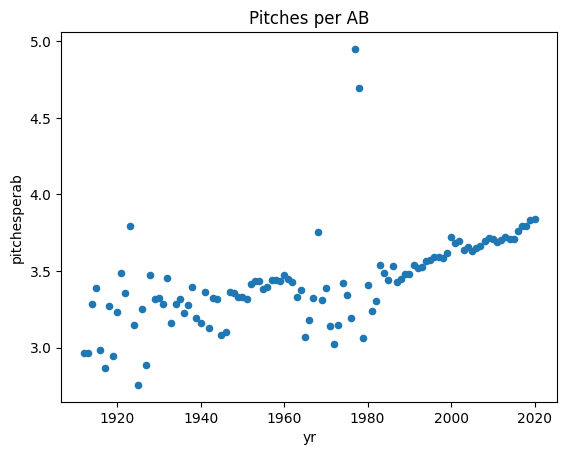

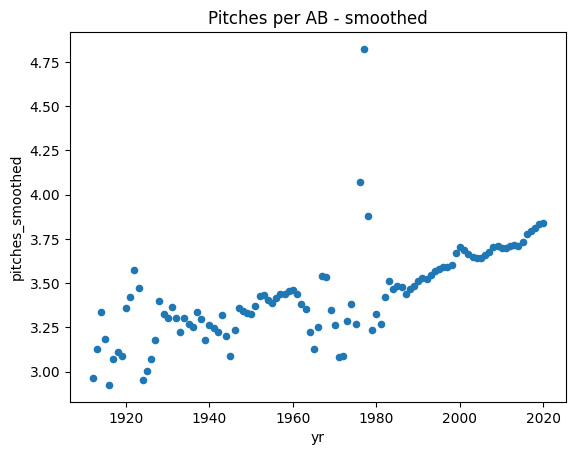

In [13]:
df.plot.scatter(x="yr", y="pitchesperab", title="Pitches per AB");
df.plot.scatter(x="yr", y="pitches_smoothed", title="Pitches per AB - smoothed")

In [19]:
local = duckdb.connect(database = "weird-stats.db", read_only = False)

In [35]:
stats = conn.sql("""
SELECT 
    player_id, 
    people.first_name, 
    people.last_name, 
    game_id, 
    wins, 
    blown_saves,
    --- MAX(substr(game_id,4,4)) 
FROM 
    player_game_pitching_stats 
    JOIN people 
        USING (player_id) 
WHERE 
    blown_saves > 0 
    AND wins > 0 
--- GROUP BY 
---    1,3,2
ORDER BY 
    substr(game_id,4,8) desc, 
    3 desc,
    2 desc
    """).df()

local.sql("""
CREATE TABLE BSwins as (SELECT
*
FROM
stats)""")

local.sql("""SELECT * FROM BSWins""").df()

,player_id,first_name,last_name,game_id,wins,blown_saves
0,bousc001,Caleb,Boushley,MIL202309290,1,1
1,clase001,Emmanuel,Clase,CLE202309220,1,1
2,stept002,Trevor,Stephan,CLE202309210,1,1
3,stepr002,Robert,Stephenson,TBA202309190,1,1
4,scott003,Tanner,Scott,MIA202309190,1,1
5,swane001,Erik,Swanson,TOR202309170,1,1
6,kingj002,John,King,SLN202309170,1,1
7,phile001,Evan,Phillips,SEA202309160,1,1
8,payaj001,Joel,Payamps,MIL202309160,1,1
9,langa001,Alex,Lange,ANA202309160,1,1


In [29]:
local.sql("""SHOW TABLES""")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ BSwins  │
└─────────┘

In [53]:
bswinsdate = local.sql("""
SELECT
    DATE(concat_ws('-',substr(game_id, 4, 4),substr(game_id,8,2), substr(game_id,10,2))) gameDate,
    COUNT(*) games,
    string_agg(concat_ws(' ', first_name, last_name),',\n') players
FROM
    BSWins
GROUP BY 1
ORDER BY
    2 desc, 1 desc
""").df()
display(bswinsdate.style.set_properties(**{'white-space' : 'pre-wrap'}))


In [56]:
local.sql("""
SELECT
    year(gameDate),
    SUM(Games)
FROM
    bswinsdate
GROUP BY 1
ORDER BY year(gameDate) desc
""").df()

,"""year""(gameDate)",sum(Games)
0,2023,60.0
1,2022,64.0
2,2021,82.0
3,2020,25.0
4,2019,69.0
5,2018,46.0
6,2017,43.0
7,2016,53.0
8,2015,49.0
9,2014,54.0


In [57]:
conn.close()

In [58]:
local.close()